In [1]:
from training_data import import_training_set

data, weights, rulesetIds = import_training_set("components classification")

In [2]:
# Remove instances involving a Random agent

# remove = data[["Selection 1 - Random", "Selection 2 - Random"]].any(axis=1)
# data = data[~remove]
# weights = weights[~remove]
# rulesetIds = rulesetIds[~remove]

In [3]:
data

,Selection 1 - ProgressiveHistory,Selection 1 - Random,Selection 1 - UCB1,Selection 1 - UCB1GRAVE,Selection 1 - UCB1Tuned,Selection 2 - ProgressiveHistory,Selection 2 - Random,Selection 2 - UCB1,Selection 2 - UCB1GRAVE,Selection 2 - UCB1Tuned,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Most common outcome for Agent 1
0,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
1,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Win
2,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Loss
3,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
4,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17877,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,Win
17878,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,Win
17879,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,Win
17880,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,Loss


In [4]:
weights

0        0.612842
1        0.612842
2        0.612842
3        0.612842
4        0.612842
           ...   
17877    0.987500
17878    0.987500
17879    0.987500
17880    0.987500
17881    0.987500
Name: 0, Length: 17882, dtype: float64

In [5]:
rulesetIds

0         37
1         37
2         37
3         37
4         37
        ... 
17877    456
17878    456
17879    456
17880    456
17881    456
Name: 0, Length: 17882, dtype: category
Categories (1017, int64): [17, 18, 30, 33, ..., 4096, 4118, 4186, 4187]

Progress: 50/1017; Time elapsed (s): 10.13; Estimated time left (s): 195.86
Progress: 100/1017; Time elapsed (s): 20.26; Estimated time left (s): 185.75
Progress: 150/1017; Time elapsed (s): 30.42; Estimated time left (s): 175.84
Progress: 200/1017; Time elapsed (s): 40.58; Estimated time left (s): 165.78
Progress: 250/1017; Time elapsed (s): 50.69; Estimated time left (s): 155.52
Progress: 300/1017; Time elapsed (s): 60.82; Estimated time left (s): 145.36
Progress: 350/1017; Time elapsed (s): 71.00; Estimated time left (s): 135.31
Progress: 400/1017; Time elapsed (s): 81.17; Estimated time left (s): 125.21
Progress: 450/1017; Time elapsed (s): 91.32; Estimated time left (s): 115.06
Progress: 500/1017; Time elapsed (s): 101.39; Estimated time left (s): 104.84
Progress: 550/1017; Time elapsed (s): 111.46; Estimated time left (s): 94.64
Progress: 600/1017; Time elapsed (s): 121.61; Estimated time left (s): 84.52
Progress: 650/1017; Time elapsed (s): 131.68; Estimated time left (s): 74.35

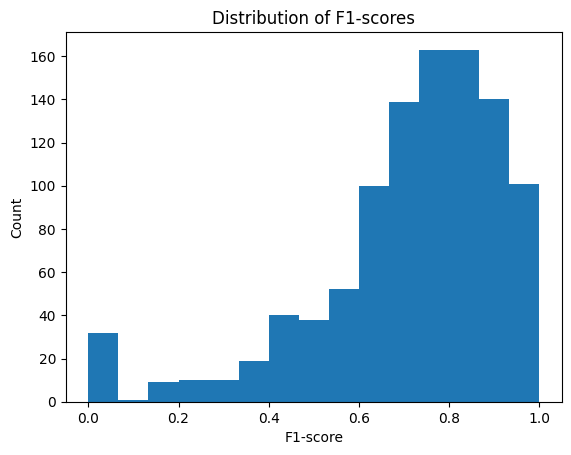

In [6]:
import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Prepare data
X = data.drop(columns=["Most common outcome for Agent 1"])
y = data["Most common outcome for Agent 1"]

# Custom implementation of Leave-One-Out Cross-Validation
scores = []
rulesetWeights = []
featureImportance = {}

startTime = time.time()
noIterations = 0
noRulesets = rulesetIds.unique().shape[0]

for rulesetId in rulesetIds.unique():
    # Train/test split
    trainIdx = (rulesetIds != rulesetId)
    X_train = X[trainIdx]
    y_train = y[trainIdx]

    testIdx = (rulesetIds == rulesetId)
    X_test = X[testIdx]
    y_test = y[testIdx]

    # Train classifier
    clf = DecisionTreeClassifier(
        max_depth=10
    ).fit(X_train, y_train, sample_weight=weights[trainIdx])

    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Determine performance of classifier
    scores.append(f1_score(y_test, y_pred, average="weighted"))
    
    # Log other important information
    rulesetWeights.append(weights[testIdx].iloc[0])
    featureImportance[rulesetId] = clf.feature_importances_
    
    # Output progress
    noIterations += 1
    if noIterations % 50 == 0:
        elapsedTime = time.time() - startTime
        avgTimePerIteration = elapsedTime / noIterations
        print(f"Progress: {noIterations}/{noRulesets}; Time elapsed (s): {elapsedTime:.2f}; Estimated time left (s): {(noRulesets - noIterations) * avgTimePerIteration:.2f}")

print(f"Progress: {noIterations}/{noRulesets}; Time elapsed (s): {time.time() - startTime:.2f}")

# Output results
print(f"\n-- Results (F1-score) --")
print(f"Minimum: {np.min(scores):.3f}\nMaximum: {np.max(scores):.3f}")
print(f"\nUnweighted average: {np.average(scores):.3f}\n  Weighted average: {np.average(scores, weights=rulesetWeights):.3f}")
print(f"\nUnweighted standard deviation: {np.std(scores):.3f}\n  Weighted standard deviation: {np.sqrt(np.cov(scores, aweights=rulesetWeights)):.3f}")

plt.hist(scores, bins=15)
plt.xlabel("F1-score")
plt.ylabel("Count")
plt.title("Distribution of F1-scores");

In [7]:
import pandas as pd

featureImportance = pd.DataFrame.from_dict(featureImportance, orient="index", columns=X.columns)

# Rank features from most to least important
avgFeatureImportance = pd.Series(np.average(featureImportance, axis=0, weights=rulesetWeights), index=featureImportance.columns)
order = avgFeatureImportance.argsort()
avgFeatureImportance.iloc[order[::-1]]

Selection 1 - Random    0.258825
Play-out 1 - Random     0.238098
Selection 2 - Random    0.113742
Play-out 2 - Random     0.111004
Play-out 1 - Random0    0.034667
                          ...   
MancalaStores           0.000000
MancalaSixRows          0.000000
InitialCost             0.000000
AutoMove                0.000000
Domino                  0.000000
Length: 184, dtype: float64

In [8]:
# Adding weights:
# (V) Add weights to training of classifier
# (V) Compute weighted average of f1-score
# (V) Compute weighted standard deviation of f1-score (?)
# (V) Change from unweighted to weighted average feature importance

In [9]:
# Custom implementation of Grid Search

# performance = {}
# 
# cntr = 0
# for max_depth in [10, 20, 30, None]:
#     for min_samples_leaf in [1, 2, 4, 6]:
#         for class_weight in ["balanced", None]:
#             key = f"{max_depth}, {min_samples_leaf}, {class_weight}"
#             
#             cntr += 1
#             print(f"\n({cntr}/32) {key}")
#             
#             performance[key] = LOOCV(max_depth, min_samples_leaf, class_weight)
# 
# values = list(performance.values())
# keys = list(performance.keys())
# 
# print()
# for i in np.flip(np.argsort(values)):
#     print(f"[{keys[i]}] -> {values[i]}")

# Output:
# [10, 1, None] -> 0.5865354421886004
# [10, 2, None] -> 0.5846582302050048
# [10, 4, None] -> 0.5834783822882802
# [10, 6, None] -> 0.5823268083985095
# [10, 1, balanced] -> 0.5663630919732909
# [10, 2, balanced] -> 0.5622313902647783
# [20, 6, None] -> 0.5589505373548773
# [10, 4, balanced] -> 0.5579925247800229
# [None, 6, None] -> 0.5566071489674502
# [20, 4, None] -> 0.5557584377599296
# [30, 6, None] -> 0.5553496095567614
# [10, 6, balanced] -> 0.5533817439485379
# [None, 4, None] -> 0.5531721308290416
# [20, 1, None] -> 0.5531245169446183
# [30, 4, None] -> 0.5528238940384855
# [20, 2, None] -> 0.5457163606865277
# [None, 1, None] -> 0.5414613030078081
# [None, 2, None] -> 0.5396737245116173
# [30, 1, None] -> 0.538537952226706
# [30, 2, None] -> 0.5382242627373885
# [None, 1, balanced] -> 0.5317614145173051
# [30, 6, balanced] -> 0.5310420144001797
# [20, 6, balanced] -> 0.5309581876952449
# [20, 4, balanced] -> 0.53035353041286
# [None, 6, balanced] -> 0.5301870375763392
# [30, 4, balanced] -> 0.530018489120621
# [20, 1, balanced] -> 0.5295648350374342
# [None, 4, balanced] -> 0.5283364073263259
# [30, 1, balanced] -> 0.5278474321982272
# [20, 2, balanced] -> 0.5217511065333372
# [None, 2, balanced] -> 0.5195658484625533
# [30, 2, balanced] -> 0.5194351472635835

In [11]:
import pickle

# Train on full data
clf = DecisionTreeClassifier(
    max_depth=10
).fit(X, y, sample_weight=weights)

# Export model
pickle.dump(clf, open("../models/decision tree.sav", 'wb'))